# Bernstein-Vazirani Algorithm

## Problem

More general version of Deutsch-Jorsza problem: we have a function $f: Z_2^n \rightarrow Z_2$ which takes $n$ bits of in input and returns one bit. This function returns the bitwise product (AND) between the input $x=(x_0,\dots,x_{n-1})$ and a string $s=(s_0,\dots,s_{n-1})$, module 2. We need to find the string $s$.

## Classical algorithm

The classical algorithm is pretty straightforward: we have an oracle which implements the function $f_s(x)=x \cdot s \text{ mod 2}$.

The hidden bit string can be revealed by sending $n$ inputs of the form $(1,0,\dots), (0,1,0,\dots)$, i.e. each with only one bit set, and the output bit would just result in the i-th bit of $s$.

This means we need to call $f_s$ a total of $n$ times.

## Quantum Alogrithm

With a QC and the correct algorithm we can solve this with 100% certainty with just one call to $f(x)$. The algorithm is simple and very similar to DJ one.

First, start with an n+1 qubit state with a n input state $|0 \dots 0>$ and an output state $|->$. Then we need to apply $H^{\otimes n}$ to the input state. Notice that if we have an n qubit state $|a>$, which is a state in the computational basis, this operation gives

\begin{equation}
H^{\otimes n} |a> = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0,1\}^n} (-1)^{a \cdot x} |x> 
\end{equation}

So the state above ends up as

$$
H^{\otimes n} |0^{\otimes n}> = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0,1\}^n} |x> = |\psi_1>
$$

A balanced superposition of all the n qubits basis states. Now, we apply the oracle as seen in DJ, and this will have the same *phase kickback* effect it had in the DJ algorithm. In fact, the function $f_s$ has the value 1 only for those x such that $s \cdot x \text{ mod 2}=1$, and 0 for all the others

$$
U_{f_s} |x> |y> = |x> |y \oplus f_s(x)>\\
U_{f_s} |x> |-> = (-1)^{s \cdot x} |x> |->
$$

So, if we ignore the output qubit

$$
U_{f_s} |\psi_1> = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0,1\}^n} (-1)^{s \cdot x} |x> = |\psi_2>
$$

Notice this is exactly the resulting state of applying $H^{\otimes n}$ to the state $|s>$, as seen before. So we can just apply the same transformation to recover this state, since H is inverse of itself:

$$
H |\psi_2> = |s>
$$

Last, we just measure all input qubits to obtain $s$.

In [1]:
from qiskit_textbook.widgets import bv_widget
bv_widget(4, "1011")

HTMLMath(value='$$ |0000\\rangle = |0000\\rangle $$')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x05\x00\x00\x01E\x08\x06\x00\x00\x00\xe5\xce\xf8…

## Implementation

Let's see an implementation for 3 qubits. Notice that the oracle can be implemented similarly to the DJ algorithm: the output of a CNOT gate is the XOR of control and target bits, so to have $s \cdot x = x_0 s_0 \oplus x_1 s_1 \oplus \dots \oplus x_{n-1} s_{n-1}$ we just need to apply a CNOT from a qubit in the input to the target, whenever the corresponding bit of s is 1. This will result in the oracle:

$$
U_{f_s} |x, y> = |x, y \oplus f_s(x)> = |x, y \oplus x \cdot s>
$$

In [5]:
# initialization
import matplotlib.pyplot as plt
import numpy as np
# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.monitor import job_monitor
# import basic plot tools
from qiskit.visualization import plot_histogram

In [3]:
n = 3 #n of qubits
s = "011" #hidden string

In [4]:
qr_1 = QuantumRegister(n, name="input")
qr_2 = QuantumRegister(1, name="output")
c_out = ClassicalRegister(n, name="measure")

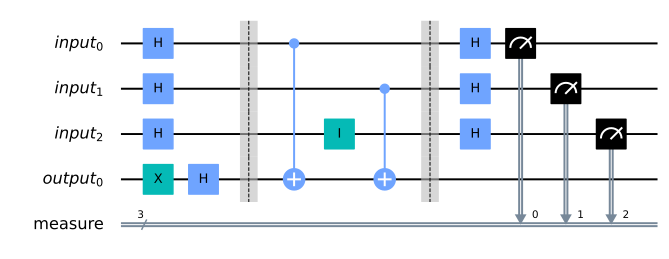

In [5]:
bv_algorithm_3 = QuantumCircuit(qr_1, qr_2, c_out)
bv_algorithm_3.x(qr_2)
bv_algorithm_3.h(qr_2)
bv_algorithm_3.h(qr_1)

bv_algorithm_3.barrier()

#Oracle
s_or = s[::-1] #we revert the bit string to fit qiskit ordering of bits (most significant on the right)
for q in range(n):
    if s_or[q]=='1':
        bv_algorithm_3.cx(q,n)
    else:
        bv_algorithm_3.i(q)
##oracle is finished
bv_algorithm_3.barrier()
bv_algorithm_3.h(qr_1)
bv_algorithm_3.measure(qr_1, c_out)
bv_algorithm_3.draw()

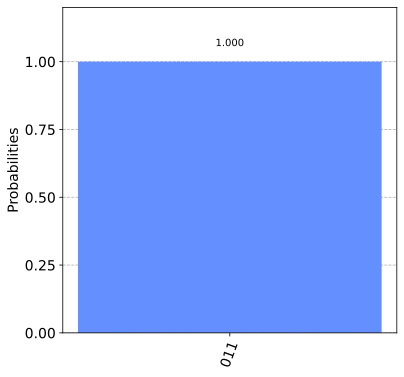

Process ForkProcess-8:
Process ForkProcess-5:
Process ForkProcess-7:
Process ForkProcess-2:
Process ForkProcess-6:
Process ForkProcess-1:
Process ForkProcess-4:
Process ForkProcess-3:
Traceback (most recent call last):


In [6]:
aer_backend = BasicAer.get_backend('qasm_simulator')
result = execute(bv_algorithm_3, aer_backend).result().get_counts()
plot_histogram(result, figsize=(6,6))

The result is the hidden string 011.

### Real devices

In [7]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
IBMQ_backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits>=(n+1) and not b.configuration().simulator and b.status().operational==True))
print("least busy backend: ", IBMQ_backend)

/home/luigi/.venvs/qiskit-textbook/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


least busy backend:  ibmq_santiago


In [8]:
job = execute(bv_algorithm_3, IBMQ_backend, shots=5000)
job_monitor(job, interval=2)

Job Status: job has successfully run


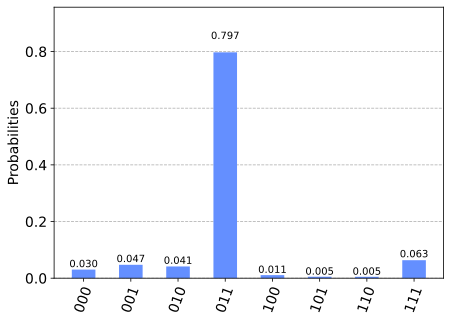

In [9]:
result = job.result().get_counts()
plot_histogram(result)

In [14]:
from qiskit_textbook.widgets import bv_widget
bv_widget(8, "11101101", hide_oracle=False)

HTMLMath(value='$$ |00000000\\rangle = |00000000\\rangle $$')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x05\x00\x00\x025\x08\x06\x00\x00\x00\xdf\x04\xef…

## General circuit

Here we develop a set of functions like in the DJ case.

In [1]:
def bv_oracle(s, qr_1, qr_2):
    oracle = QuantumCircuit(qr_1, qr_2)
    s_or = s[::-1]
    for q in range(qr_1.size):
        if s_or[q]=='1':
            oracle.cx(q,qr_2)
    oracle_gate = oracle.to_gate()
    oracle_gate.name = "Oracle"
    return oracle_gate

In [2]:
def bv_algorithm(oracle, qr_1, qr_2, c_out):
    bv_circuit = QuantumCircuit(qr_1, qr_2, c_out)
    bv_circuit.x(qr_2)
    bv_circuit.h(qr_2)
    bv_circuit.h(qr_1)
    
    bv_circuit.barrier()
    bv_circuit.append(oracle, range(qr_1.size+1))
    bv_circuit.barrier()
    
    bv_circuit.h(qr_1)
    bv_circuit.measure(qr_1,c_out)
    return bv_circuit

In [3]:
def bv_algo_full(s):
    n = len(s)
    qr_1 = QuantumRegister(n, name="input")
    qr_2 = QuantumRegister(1, name="output")
    c_out = ClassicalRegister(n, name="measure")
    
    oracle = bv_oracle(s, qr_1, qr_2)
    circuit = bv_algorithm(oracle, qr_1, qr_2, c_out)
    
    return circuit

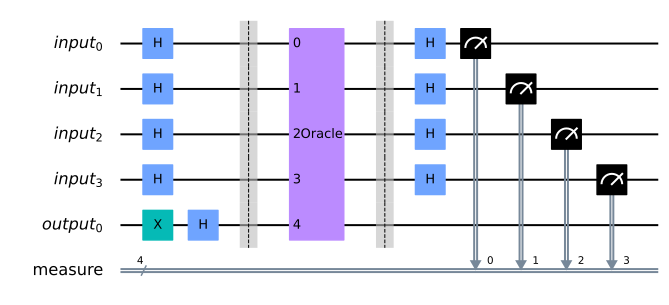

In [17]:
test_circuit = bv_algo_full("1011")
test_circuit.draw()

In [10]:
aer_backend = BasicAer.get_backend('qasm_simulator')

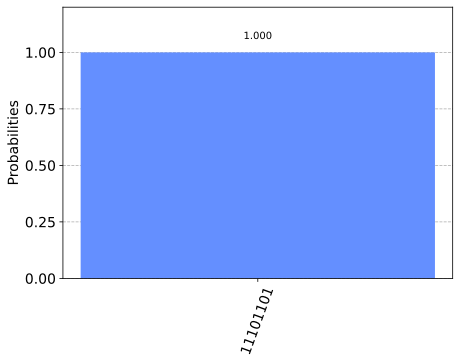

In [11]:
result = execute(test_circuit, aer_backend, shots=10000).result().get_counts()
plot_histogram(result)

In [18]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

/home/luigi/.venvs/qiskit-textbook/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2020-12-18 18:30:28,213: Credentials are already in use. The existing account in the session will be replaced.


NameError: name 'IBMQ_backendbackend' is not defined

In [23]:
IBMQ_backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits>=5 and not b.configuration().simulator and b.status().operational==True))

In [24]:
print("least busy backend: ", IBMQ_backend, ", Qubits: ", IBMQ_backend.configuration().n_qubits)

least busy backend:  ibmq_santiago , Qubits:  5


In [25]:
from qiskit.tools.monitor import job_monitor
job = execute(test_circuit, IBMQ_backend, shots=2048)
job_monitor(job, interval=2)

Job Status: job has successfully run


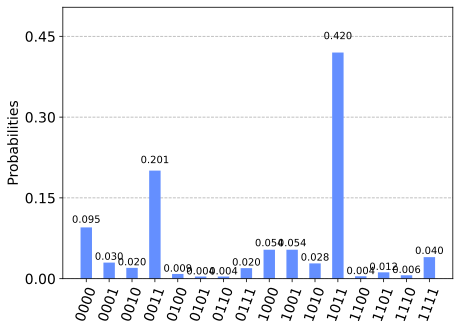

In [26]:
result = job.result().get_counts()
plot_histogram(result)